Implement a Fully Connected AutoEncoder in Python (you can use TensorFlow or pytorch)

Start by importing libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive/') 

import torch; 
#Sets the seed for generating random numbers.
torch.manual_seed(0)

#torch. nn import gives us access to some helpful neural network things, such as various neural network layer types (things like regular fully-connected layers, convolutional layers (for imagery), recurrent layers...etc).
import torch.nn as nn 

#applies Convolution functions
import torch.nn.functional as F

#allow to access pre-loaded datasets as well as your own data
import torch.utils

#contains parameterizable probability distributions and sampling functions
import torch.distributions

#consists of popular datasets, model architectures, and common image transformations for computer vision
import torchvision

import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

import torchvision.transforms as transforms

transform = transforms.Compose([
    # # resize
    # transforms.Resize(28),
    # # center-crop
    # transforms.CenterCrop(32),
    # to-tensor
    transforms.ToTensor(),
    # # normalize
    # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

Mounted at /content/drive/


In [3]:
#Check GPU Availability
torch.cuda.is_available()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Define Encoder and Decoder class, and combine them into an autoencoder

In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

Your AutoEncoder should have a bottleneck with two neurons and Mean Squared Error (MSE) as the objective function. In an AutoEncoder, the layer with the least number of neurons is referred to as a bottleneck.

Train your model on MNIST. Start by loading training / testing of MNIST

In [5]:
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}
batch_size=128
trainset=torchvision.datasets.MNIST('/files/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset,
  batch_size=batch_size, **kwargs)

testset=torchvision.datasets.MNIST('files/', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset,
  batch_size=batch_size, **kwargs)

100%|██████████| 9912422/9912422 [00:00<00:00, 91627113.77it/s]


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 42488843.85it/s]


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25159034.06it/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4273335.30it/s]


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 102569209.89it/s]

Extracting files/MNIST/raw/train-images-idx3-ubyte.gz to files/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 114820562.87it/s]


Extracting files/MNIST/raw/train-labels-idx1-ubyte.gz to files/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25461642.72it/s]


Extracting files/MNIST/raw/t10k-images-idx3-ubyte.gz to files/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21972928.22it/s]

Extracting files/MNIST/raw/t10k-labels-idx1-ubyte.gz to files/MNIST/raw



Define classes / image function


In [6]:
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

def imshow(img):
     img = img / 2 + 0.5
     npimg = img.numpy()
     plt.imshow(np.transpose(npimg, (1, 2, 0)))
     plt.show()

Create a training function for the autoencoder to work on the data


In [9]:
def train(autoencoder, traindata, testdata, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    losstrain = np.zeros(epochs)
    losstest = np.zeros(epochs)
    for epoch in range(epochs):
        for x, y in traindata:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).mean()
            losstrain[epoch]=loss
            loss.backward()
            opt.step()
        print(f'Epoch {epoch+1}, Training Loss: {loss:.4f}')
        for x, y in testdata:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).mean()
            losstest[epoch]=loss
        print(f'Epoch {epoch+1}, Test Loss: {loss:.4f}')
    return autoencoder, losstrain, losstest

Train through the data. By setting latent dims to 2, we make the bottleneck 2 neurons. 

In [8]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU

autoencoder = train(autoencoder, trainset, testset)

Epoch 1, Training Loss: 0.0505
Epoch 1, Test Loss: 0.0471
Epoch 2, Training Loss: 0.0492
Epoch 2, Test Loss: 0.0419
Epoch 3, Training Loss: 0.0476
Epoch 3, Test Loss: 0.0394
Epoch 4, Training Loss: 0.0466
Epoch 4, Test Loss: 0.0418
Epoch 5, Training Loss: 0.0468
Epoch 5, Test Loss: 0.0381
Epoch 6, Training Loss: 0.0467
Epoch 6, Test Loss: 0.0348
Epoch 7, Training Loss: 0.0468
Epoch 7, Test Loss: 0.0336
Epoch 8, Training Loss: 0.0479
Epoch 8, Test Loss: 0.0381
Epoch 9, Training Loss: 0.0453
Epoch 9, Test Loss: 0.0371
Epoch 10, Training Loss: 0.0460
Epoch 10, Test Loss: 0.0328
Epoch 11, Training Loss: 0.0463
Epoch 11, Test Loss: 0.0349
Epoch 12, Training Loss: 0.0472
Epoch 12, Test Loss: 0.0326
Epoch 13, Training Loss: 0.0451
Epoch 13, Test Loss: 0.0346
Epoch 14, Training Loss: 0.0446
Epoch 14, Test Loss: 0.0316
Epoch 15, Training Loss: 0.0461
Epoch 15, Test Loss: 0.0364
Epoch 16, Training Loss: 0.0456
Epoch 16, Test Loss: 0.0380
Epoch 17, Training Loss: 0.0457
Epoch 17, Test Loss: 0.036

 Plot the train and test loss.

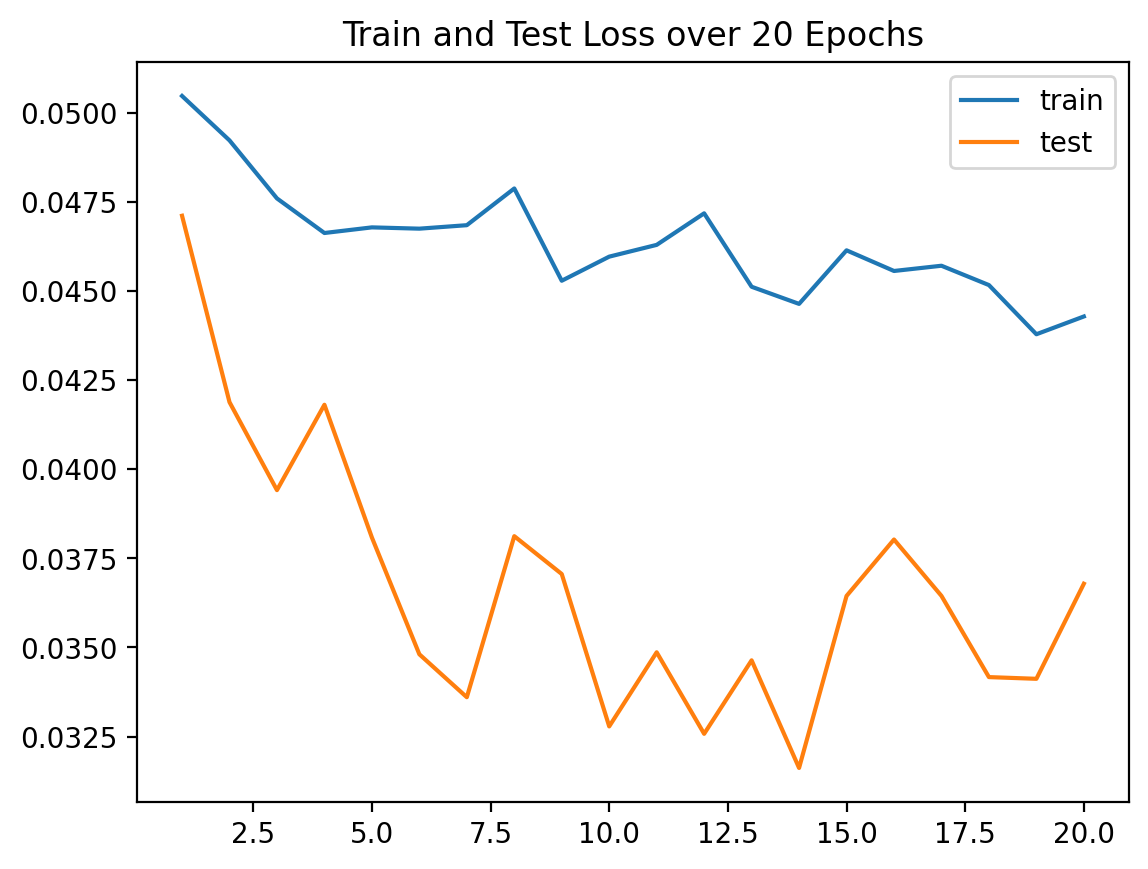

In [10]:
plt.plot(np.linspace(1,20,20), autoencoder[1], label="train")
plt.plot(np.linspace(1,20,20), autoencoder[2], label="test")
plt.title("Train and Test Loss over 20 Epochs")
plt.legend()
plt.show()

Randomly select 10 images from the test set, encode them and visualize the decoded images.

In [63]:
# get a random image from test
test_loader = torch.utils.data.DataLoader(testset,
  batch_size=1, **kwargs, shuffle=True)

<Figure size 2000x400 with 0 Axes>

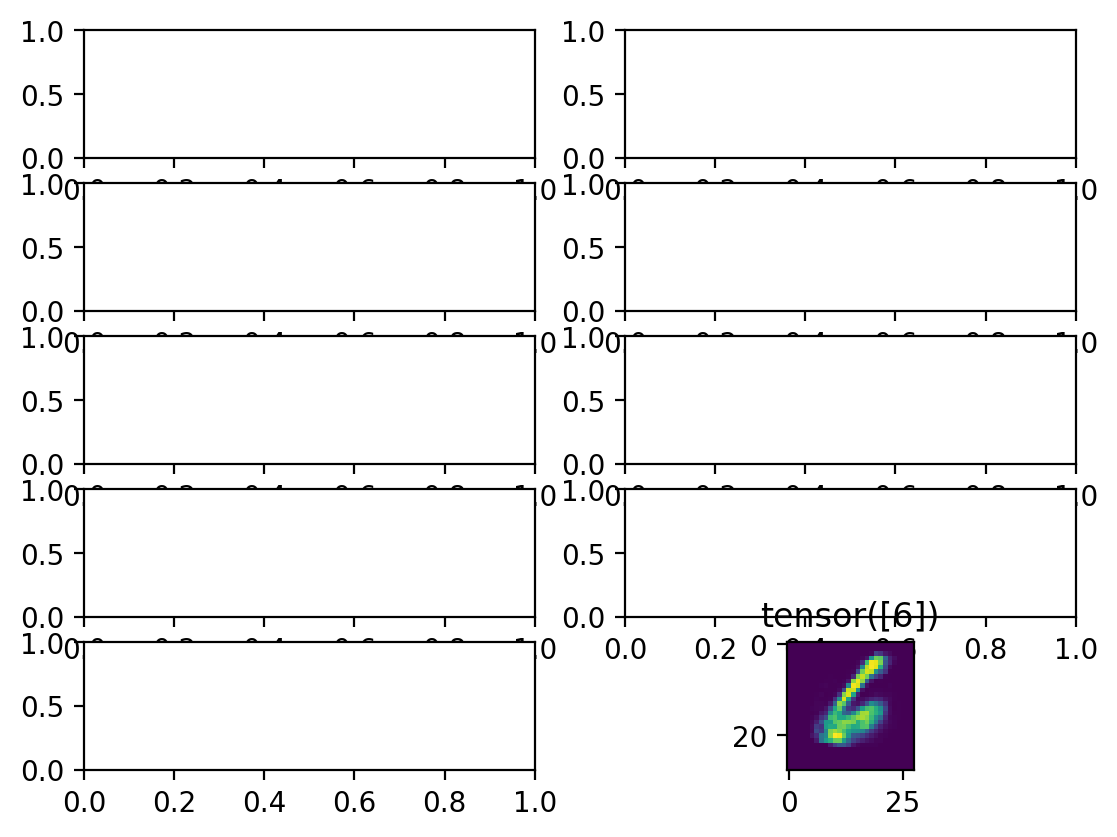

In [84]:
# plt.figure(figsize=(10, 2))
# plt.subplots(5,2)
def plot_latent(autoencoder, data):
    # 28 by 28 pixels
    w = 28
    img = np.zeros((w, w))
    for i, (x, y) in enumerate(data):
        plt.title(y)
        z = autoencoder.encoder(x.to(device))
        x_hat = autoencoder.decoder(z)
        z = z.to('cpu').detach().numpy()
        x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
    plt.imshow(x_hat)

# for i in range(1,10):
#   dataiter = iter(test_loader)
#   images, labels = next(dataiter)
#   plot_latent(autoencoder[0], dataiter)

#imshow(torchvision.utils.make_grid(images)) 
#plot_latent(autoencoder[0], test_loader)

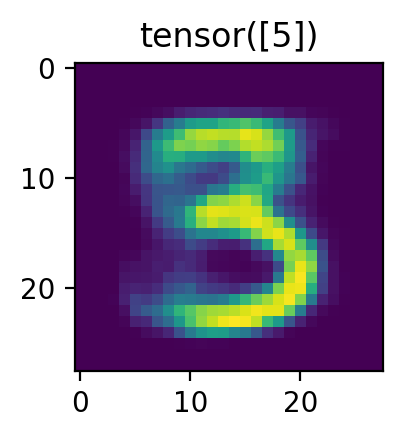

In [85]:
#1
plt.figure(figsize=(10, 2))

dataiter = iter(test_loader)
images, labels = next(dataiter)
plot_latent(autoencoder[0], dataiter)

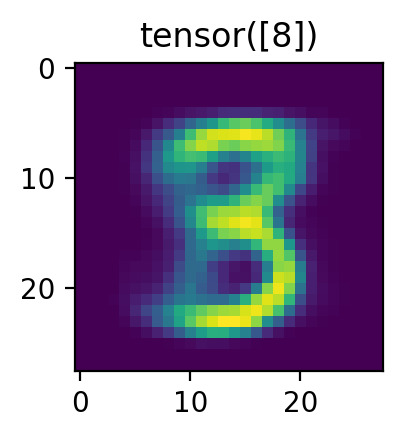

In [86]:
#2
plt.figure(figsize=(10, 2))

dataiter = iter(test_loader)
images, labels = next(dataiter)
plot_latent(autoencoder[0], dataiter)

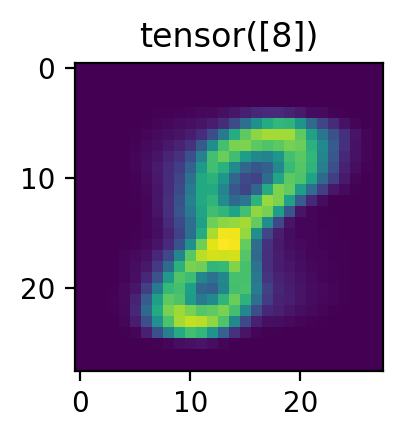

In [87]:
#3
plt.figure(figsize=(10, 2))

dataiter = iter(test_loader)
images, labels = next(dataiter)
plot_latent(autoencoder[0], dataiter)

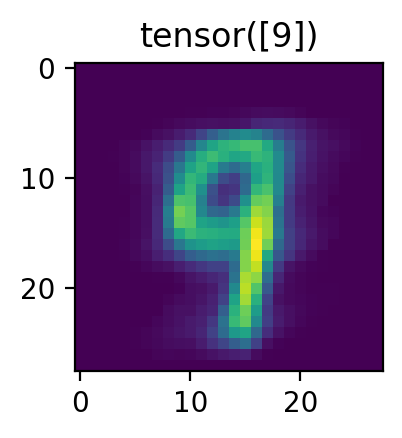

In [88]:
#4
plt.figure(figsize=(10, 2))

dataiter = iter(test_loader)
images, labels = next(dataiter)
plot_latent(autoencoder[0], dataiter)

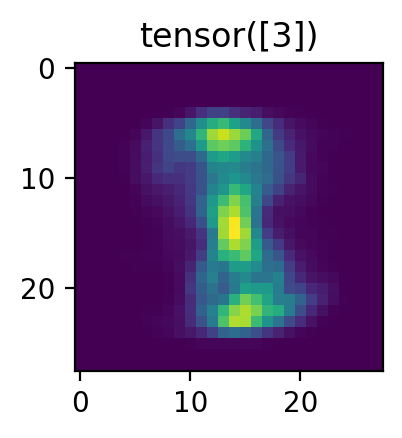

In [89]:
#5
plt.figure(figsize=(10, 2))

dataiter = iter(test_loader)
images, labels = next(dataiter)
plot_latent(autoencoder[0], dataiter)

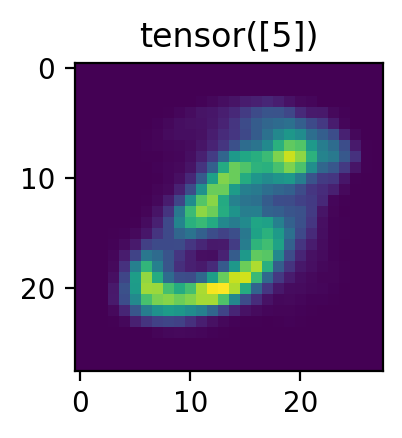

In [90]:
#6
plt.figure(figsize=(10, 2))

dataiter = iter(test_loader)
images, labels = next(dataiter)
plot_latent(autoencoder[0], dataiter)

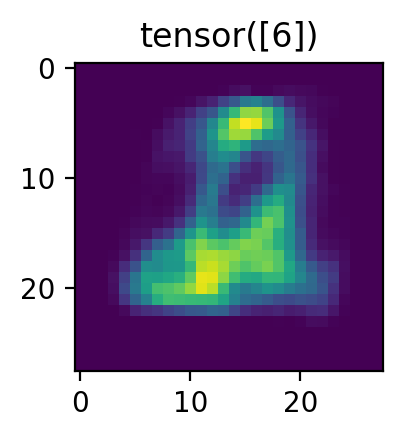

In [91]:
#7
plt.figure(figsize=(10, 2))

dataiter = iter(test_loader)
images, labels = next(dataiter)
plot_latent(autoencoder[0], dataiter)

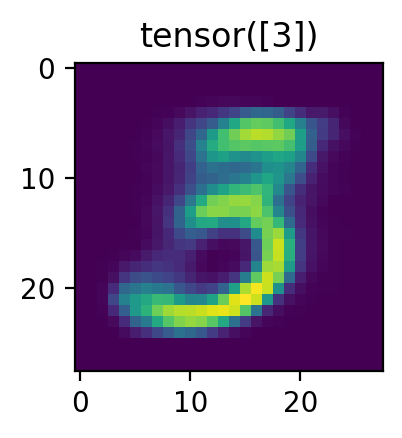

In [92]:
#8
plt.figure(figsize=(10, 2))

dataiter = iter(test_loader)
images, labels = next(dataiter)
plot_latent(autoencoder[0], dataiter)

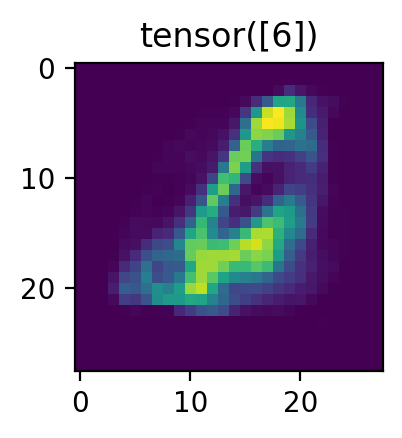

In [93]:
#9
plt.figure(figsize=(10, 2))

dataiter = iter(test_loader)
images, labels = next(dataiter)
plot_latent(autoencoder[0], dataiter)

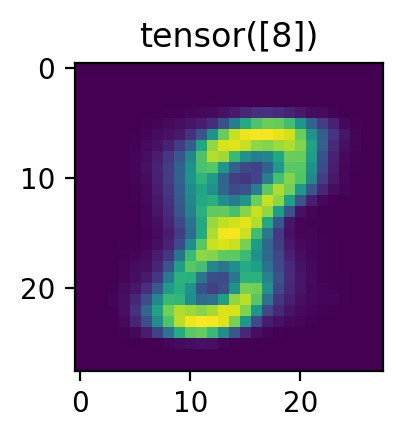

In [94]:
#10
plt.figure(figsize=(10, 2))

dataiter = iter(test_loader)
images, labels = next(dataiter)
plot_latent(autoencoder[0], dataiter)

References: 
https://avandekleut.github.io/vae/ 

Thank you to the lecture notes from Dr. Hansapani Rodrigo, Assistant Professor @ UTRGV